In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras (Keras layers below)
from tensorflow.keras.utils import set_random_seed, to_categorical
set_random_seed(1234) # set the seeds for Python, NumPy, and TensorFlow in order to reproduce the results

# Custom
import sys
sys.path.insert(0, '/home/lcastellazzi/MDM32/src/utils')
from preprocessing import TraceHandler
from nicv import nicv
import constants
from postprocessing import SingleByteEvaluator


# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
paths = {'train': '/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs', # D1_K1
         'test' : '/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs'} # D1_K2

trace_handlers = {key: TraceHandler(path) for key, path in paths.items()}

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2306.77it/s]


In [3]:
BYTE_IDX = 0
N_CLASSES = 256

x_train_tot = trace_handlers['train'].get_traces()
y_train_tot = trace_handlers['train'].get_specific_labels(BYTE_IDX)
y_train_tot_cat = to_categorical(y_train_tot, N_CLASSES)

x_test, y_test = trace_handlers['test'].generate_test(BYTE_IDX) 
y_test_cat = to_categorical(y_test, N_CLASSES)

In [64]:
from tensorflow.keras.optimizers import Adam, RMSprop

hp = {'input_size':         len(x_train_tot[0]), # 1237
      'batch_norm':         [True, False],
      'kernel_initializer': ['random_normal', 'he_normal'],
      'num_hidden_layers':  [1, 2, 3, 4, 5],
      'num_hidden_neurons': [100, 200, 300, 400, 500],
      'dropout':            [True, False],
      'dropout_rate':       [0.0, 0.2, 0.4],
      'batch_size':         100,
      'lr':                 [1e-3, 1e-4, 1e-5],
      'opt':                [Adam, RMSprop]}

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

import random

LOSS = 'categorical_crossentropy'

def build_model(hp):

    chosen_hp = {'BATCH_NORM': random.choice(hp['batch_norm']),
                 'KERNEL_INITIALIZER': random.choice(hp['kernel_initializer']),
                 'NUM_HIDDEN_LAYERS': random.choice(hp['num_hidden_layers']),
                 'NUM_HIDDEN_NEURONS': random.choice(hp['num_hidden_neurons']),
                 'DROPOUT': random.choice(hp['dropout']),
                 'DROPOUT_RATE': random.choice(hp['dropout_rate']),
                 'LR': random.choice(hp['lr']), 
                 'OPT': random.choice(hp['opt'])}
    
    ############################################################
    # Init model
    model = Sequential()

    # Input
    model.add(Dense(hp['input_size'], 
                    kernel_initializer=chosen_hp['KERNEL_INITIALIZER'], 
                    activation='relu'))

    # Batch Normalization
    # if chosen_hp['BATCH_NORM']:
    model.add(BatchNormalization())

    # Hidden
    for _ in range(chosen_hp['NUM_HIDDEN_LAYERS']):
        model.add(Dense(chosen_hp['NUM_HIDDEN_NEURONS'], 
                        kernel_initializer=chosen_hp['KERNEL_INITIALIZER'],
                        activation='relu'))

        # Dropout
        if chosen_hp['DROPOUT']:
            model.add(Dropout(chosen_hp['DROPOUT_RATE']))

    # Batch Normalization
    # if chosen_hp['BATCH_NORM']:
    model.add(BatchNormalization())

    # Output
    model.add(Dense(N_CLASSES, activation='softmax'))
    ############################################################

    model.compile(optimizer=chosen_hp['OPT'](learning_rate=chosen_hp['LR']),
                  loss=LOSS,
                  metrics=['accuracy'])
                                        
    return model, chosen_hp

In [66]:
N_MODELS = 5

models = [build_model(hp) for _ in range(N_MODELS)]

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=5)

In [ ]:
from sklearn.model_selection import KFold

true_key_byte = trace_handlers['train'].get_key()[BYTE_IDX]

N_EXP = 10
N_EPOCHS = 100

kf = KFold(n_splits=N_EXP)

guessing_entropies = []
for m, model_hp in enumerate(models):
    curr_model, curr_hp = model_hp
    curr_ranks = []
    
    # Train + Val
    for e, idxs in enumerate(kf.split(x_train_tot[:5000])):
        print()
        print()
        print(f'------------------------------ Model {m}/{N_MODELS-1} - Experiment {e+1}/{N_EXP} ------------------------------')
        
        # Setup the current train and val sets
        train_idxs, val_idxs = idxs

        x_train = x_train_tot[train_idxs]
        y_train = y_train_tot_cat[train_idxs]

        x_val = x_train_tot[val_idxs]
        y_val = y_train_tot_cat[val_idxs]

        # Fit the model
        curr_model.fit(x_train, 
                       y_train,
                       epochs=N_EPOCHS,
                       batch_size=hp['batch_size'],
                       callbacks=[es],
                       verbose=1)
        
        # Get the plaintexts relative to the current val set
        curr_val_plaintexts = trace_handlers['train'].get_plaintexts()[val_idxs]
        
        # Evaluate the model after each train gradually incrementing the number of test traces (same max for each experiment) 
        label_preds = curr_model.predict(x_val)

        evaluator = SingleByteEvaluator(test_plaintexts=curr_val_plaintexts,
                                        byte_idx=BYTE_IDX,
                                        label_preds=label_preds)
        
        tmp_ranks = []
        for i in tqdm(range(len(curr_val_plaintexts)), desc=f'Evaluating Experiment {e+1}/{N_EXP}: '):
            num_traces = i + 1
            tmp_ranks.append(evaluator.rank(true_key_byte, num_traces))

        tmp_ranks = np.array(tmp_ranks)
        curr_ranks.append(tmp_ranks)

    curr_ranks = np.array(curr_ranks)
    rounded_mean = np.round(np.mean(curr_ranks, axis=0)) # .5 approximated to the next int
    guessing_entropies.append(rounded_mean)

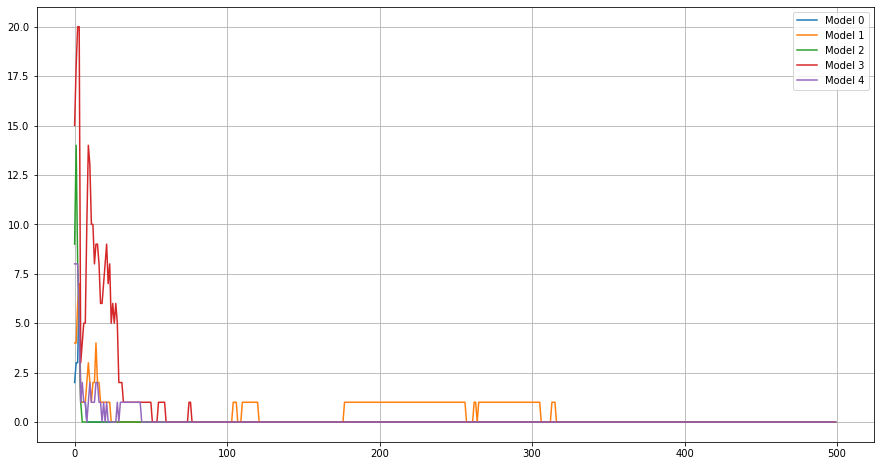

In [69]:
guessing_entropies = np.array(guessing_entropies)

plt.figure(figsize=(15, 8))

for i, ge in enumerate(guessing_entropies):
    plt.plot(ge, marker='', label=f'Model {i}')

plt.grid()
plt.legend()
plt.show()

In [70]:
min_ge_values = [ge.tolist().index(0) if 0 in ge else len(x_val) for ge in guessing_entropies]
min_ge = min(min_ge_values)
best_model_idx = min_ge_values.index(min_ge)

In [71]:
final_model, final_hp = models[best_model_idx]

print(f'Best Model: {best_model_idx}')
print(f'Best Model Hyperparameters: {final_hp}')
print()

final_model.fit(x_train_tot, 
                y_train_tot_cat,
                epochs=N_EPOCHS,
                batch_size=hp['batch_size'],
                callbacks=[es],
                verbose=1)

Best Model: 2
Best Model Hyperparameters: {'BATCH_NORM': True, 'KERNEL_INITIALIZER': 'he_normal', 'NUM_HIDDEN_LAYERS': 3, 'NUM_HIDDEN_NEURONS': 500, 'DROPOUT': False, 'DROPOUT_RATE': 0.2, 'LR': 0.0001, 'OPT': <class 'keras.optimizer_v2.adam.Adam'>}

Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 5.6141 - accuracy: 0.0454
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 4.4853 - accuracy: 0.0750
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 4.2881 - accuracy: 0.0945
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 4.1295 - accuracy: 0.1142
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 3.9865 - accuracy: 0.1309
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 3.8455 - accuracy: 0.1525
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 3.7142 - accuracy: 0.1689
Epoch 8/100
500/500 [======================

100%|██████████| 5000/5000 [00:18<00:00, 277.60it/s] 


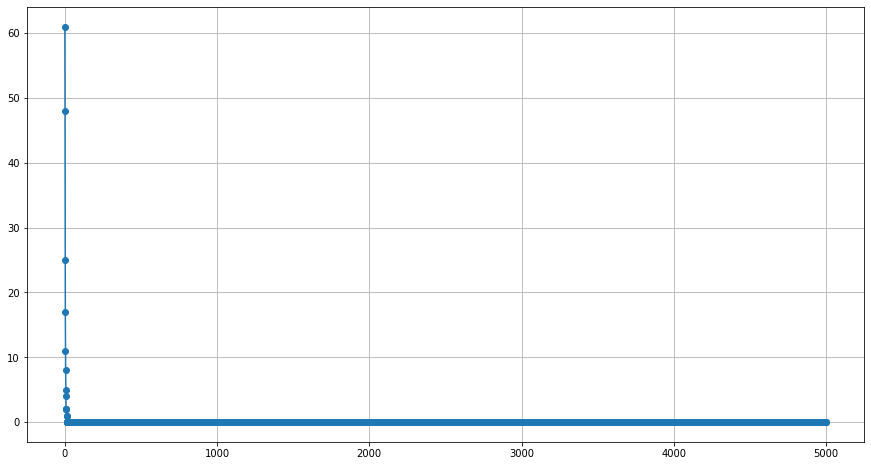

In [72]:
test_plaintexts = trace_handlers['test'].get_plaintexts()
true_key_byte = trace_handlers['test'].get_key()[BYTE_IDX]

N_TESTS = 10
SINGLE_TEST_SIZE = int(len(x_test) / N_TESTS)

ranks = []
for i in range(N_TESTS):
    start = i * SINGLE_TEST_SIZE
    end = start + SINGLE_TEST_SIZE
    
    curr_preds = final_model.predict(x_test[start:end])

    curr_plaintexts = test_plaintexts[start:end]
    curr_evaluator = SingleByteEvaluator(test_plaintexts=curr_plaintexts,
                                         byte_idx=BYTE_IDX,
                                         label_preds=curr_preds)
    curr_ranks = []
    for j in tqdm(range(SINGLE_TEST_SIZE)):
        num_traces = j + 1
        curr_ranks.append(curr_evaluator.rank(true_key_byte, num_traces))

    curr_ranks = np.array(curr_ranks)
    ranks.append(curr_ranks)

ranks = np.array(ranks)
    
guessing_entropy = np.round(np.mean(ranks, axis=0)) # .5 approximated to the next int

plt.figure(figsize=(15, 8))
plt.plot(guessing_entropy)
plt.grid()
plt.show()

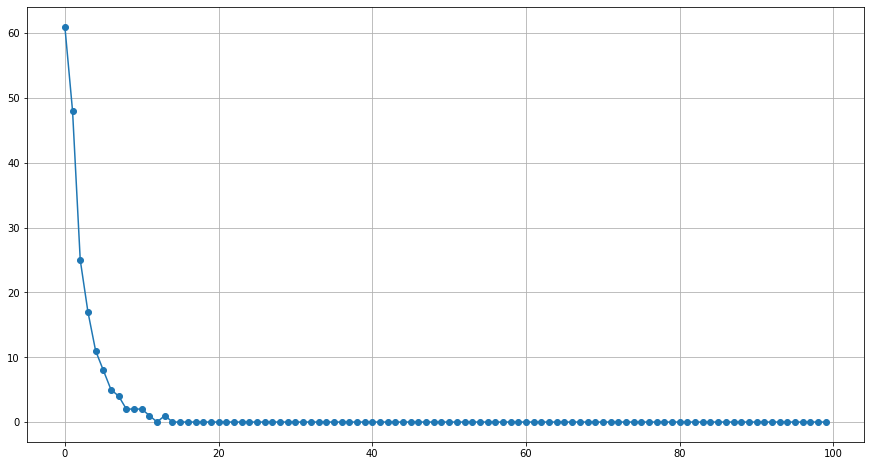

In [73]:
plt.figure(figsize=(15, 8))
plt.plot(guessing_entropy[:100], marker='o')
plt.grid()
plt.show()